In [1]:
import sys
sys.path.append("..") #to accomodate the ordinal.py that is located in the directory above

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
from math import log, ceil 
import seaborn as sns
import json

from ordinal import Ordinal #directory above

from scipy.stats import pearsonr

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer

from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xverse.transformer import WOE
# from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
import pickle

from imblearn import FunctionSampler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,TransformerMixin
from sklearn.preprocessing import StandardScaler,FunctionTransformer

from sklearn import metrics
from sklearn.model_selection import cross_val_score


### data reading

In [43]:
df=pd.read_csv("dataset/credit_risk_dataset.csv")
df=df[~df.duplicated(keep='first')]
# df=df.sample(1000)

SEED=133

potential outliers on person_emp_length (123 years? really?) and person_age (how many live up to even 144 these days)

defining feature types:

In [32]:
list(df.columns[df.isnull().any()])

['person_emp_length', 'loan_int_rate']

In [41]:
list(set(df.select_dtypes(np.number).columns).intersection(set(df.columns[df.isnull().any()])))

['loan_int_rate', 'person_emp_length']

In [13]:
obje = df.select_dtypes(np.object) #object dtypes
nume_and_target=df.select_dtypes(np.number) #number dtypes 

target = ['loan_status']
ordi = ['loan_grade'] #categorical feature to be ordinal
cate = list(obje[obje.columns.difference(ordi)].columns) #categorical features to be dummy vars
nume = list(nume_and_target[nume_and_target.columns.difference(target)].columns) #numerical features without target

all_feat = nume + cate + ordi

# columns_with_nan=df[df.columns[df.isnull().any()]].isnull().sum() * 100 / df.shape[0]

# columns_to_impute = columns_with_nan[columns_with_nan<67].index.tolist() #OVER THAN 64, DROPPED
nan_cols=list(set(nume).intersection(set(columns_to_impute)))

#### split

In [14]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
df.drop('loan_status',axis=1), df['loan_status'], test_size=0.2, random_state=SEED)

In [55]:
nume

['cb_person_cred_hist_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'person_age',
 'person_emp_length',
 'person_income']

In [73]:
# s={}
s.update({3232:'asd'})
s

{2: 'asd', 32: 'asd', 3232: 'asd'}

In [ ]:
from sklearn.pipeline import TransformerMixin

class Ordinal(TransformerMixin):
    def __init__(self,nume):
        self.nume=nume

    def fit(self, X, y=None):
        self.batas={}
        for feat in self.nume:
            self.batas.update({feat:(outlier_treatment(X[feat]))})
        return self

    def transform(self, X):
        for feat in self.nume:
            X[feat] = X[feat].map(self.ordinal_ranking)
        return X

In [63]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = min(datacolumn) - (1.5 * IQR)
    upper_range = max(datacolumn) + (1.5 * IQR)
    return lower_range,upper_range
    
outlier_treatment(df.person_age)

(9.5, 154.5)

### data preprocessing

# funcs 

In [15]:
def print_evaluate(true, predicted):
    auc = metrics.roc_auc_score(true, predicted)
    accuracy = metrics.accuracy_score(true, predicted)
    print('Accuracy:', accuracy)
    print('AUC:', auc)
    print('__________________________________')
    
def evaluate(true, predicted):
    auc = metrics.roc_auc_score(true, predicted)
    accuracy = metrics.accuracy_score(true, predicted)
    precision = metrics.precision_score(true, predicted)
    recall = metrics.recall_score(true, predicted)

    return accuracy, auc, precision, recall

# pipeline

In [16]:
nume_pipe = Pipeline(steps=[
    ('imputer_nume', SimpleImputer(missing_values=np.nan,strategy='median'))
])

ordi_pipe = Pipeline(steps=[
    ('ordinal', Ordinal(ordi)),
    ('imputer_ordi', SimpleImputer(missing_values=np.nan,strategy='mean'))
])

cate_pipe = Pipeline(steps=[
    ('scaler_cate', OneHotEncoder(handle_unknown='ignore')),
])

preprocess = ColumnTransformer(transformers=[
    ('nan', nan_pipe, nume-ordi),
    ('ordi', ordi_pipe, ordi),
    ('cate', cate_pipe, cate),
], remainder='passthrough')

xgb = XGBClassifier(min_child_weight = 3,
                    subsample = 0.5,
                    random_state = SEED)

full_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
     ('model', xgb)])

**missing values handling**

Each category of the columns are handling this problem uniquely:
- Categorical columns **do not explicitly handle** it because it was actually already handle by the brilliant feature 'handle_unknown' offered by sklearn's OneHotEncoder and setting it to 'ignore': new values that weren't seen on train set will just not be assigned to any of the dummy columns of the feature (all 0s).
- Numerical columns handle it with **'median'** method as usual.
- Ordinal columns replace the missing values with **'mean'**, because the distribution of ordinal values are sometimes far from Gaussian; and when the first number already represents more than half of the data, then the value will be set to its first number, not counting at all the values on the other extreme that might also contribute. The 'mean' method seems fairer for this case (and other more usual cases too).

**outliers handling**

Each category of the columns are handling this problem uniquely:
- Categorical columns **do not explicitly handle** it because it was actually already handle by the brilliant feature 'handle_unknown' offered by sklearn's OneHotEncoder and setting it to 'ignore': new values that weren't seen on train set will just not be assigned to any of the dummy columns of the feature (all 0s).
- Numerical columns handle it with **'median'** method as usual.
- Ordinal columns replace the missing values with **'mean'**, because the distribution of ordinal values are sometimes far from Gaussian; and when the first number already represents more than half of the data, then the value will be set to its first number, not counting at all the values on the other extreme that might also contribute. The 'mean' method seems fairer for this case (and other more usual cases too).

In [51]:
df.groupby('loan_grade').count()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
loan_grade,,,,,,,,,,,
A,10703,10703,10703,10301,10703,10703,9713,10703,10703,10703,10703
B,10387,10387,10387,10124,10387,10387,9337,10387,10387,10387,10387
C,6438,6438,6438,6303,6438,6438,5809,6438,6438,6438,6438
D,3620,3620,3620,3550,3620,3620,3309,3620,3620,3620,3620
E,963,963,963,951,963,963,880,963,963,963,963
F,241,241,241,236,241,241,214,241,241,241,241
G,64,64,64,64,64,64,59,64,64,64,64


In [17]:
param_space = {
    "model__eta": [0.3,0.4],
    "model__gamma": [2,4],
    "model__n_estimators": [800,1100],
    "model__max_depth": [10,20],
}

clf = GridSearchCV(full_pipe, 
                   param_space, 
                   scoring='roc_auc',
                   n_jobs=-1,
                   cv=4, 
                   refit=True,verbose=2)

In [18]:
clf.fit(X_train, y_train)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed: 21.7min finished
C:\Users\4\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:33:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.940324 using {'model__eta': 0.3, 'model__gamma': 4, 'model__max_depth': 10, 'model__n_estimators': 800}


In [19]:
test_pred_all = clf.best_estimator_.predict(X_holdout)
test_pred_proba_all = clf.best_estimator_.predict_proba(X_holdout)

train_pred_all = clf.best_estimator_.predict(X_train)

lis_train_val_acc_all_logreg=list(evaluate(y_train, train_pred_all))+list(evaluate(y_holdout, test_pred_all))

index = pd.MultiIndex.from_product([['train metrics', 'validation metrics'], ['Accuracy', 'AUC','Precision','Recall']])
result_logreg_opt = pd.DataFrame([lis_train_val_acc_all_logreg], columns=index)
result_logreg_opt.insert(loc=0, column='train data', value = ['all feats'])

result_logreg_opt

train data train metrics                               validation metrics  \
                  Accuracy       AUC Precision    Recall           Accuracy   
0  all feats      0.978212  0.952859  0.991707  0.907839           0.928285   

                                 
        AUC Precision    Recall  
0  0.864063  0.908163  0.749474

#### save model

In [20]:
MODELNAME = 'xgb_to_deploy.pkl'
PREPROCESSNAME = 'pipe_to_deploy.pkl'

final_model = clf.best_estimator_.named_steps['model']
final_pipe = clf.best_estimator_.named_steps['preprocess']

with open('../saved_models/'+MODELNAME, 'wb') as f: # save model
    pickle.dump(final_model, f)
    
with open('../saved_models/'+PREPROCESSNAME, 'wb') as f: # save pipeline
    pickle.dump(final_pipe, f)

#### for production testing

In [21]:
holdout_res=pd.concat([X_holdout.reset_index(drop=True),
           pd.DataFrame(test_pred_all),
           pd.DataFrame(test_pred_proba_all).loc[:,1].reset_index(drop=True)],
           axis=1)
holdout_res=holdout_res.rename(columns = {0:'loan_status_predict',1:'loan_status_proba'})
holdout_res_sample=holdout_res.sample(2,random_state=SEED)
holdout_res_sample.T

,2312,3631
person_age,30,28
person_income,82000,58000
person_home_ownership,MORTGAGE,MORTGAGE
person_emp_length,5.0,0.0
loan_intent,PERSONAL,VENTURE
loan_grade,A,C
loan_amnt,5000,12500
loan_int_rate,6.76,13.43
loan_percent_income,0.06,0.22
cb_person_default_on_file,N,N


the sample for testing the proba prediction on deployment:

In [22]:
dic=holdout_res_sample.to_dict(orient='records')
dic

[{'person_age': 30,
  'person_income': 82000,
  'person_home_ownership': 'MORTGAGE',
  'person_emp_length': 5.0,
  'loan_intent': 'PERSONAL',
  'loan_grade': 'A',
  'loan_amnt': 5000,
  'loan_int_rate': 6.76,
  'loan_percent_income': 0.06,
  'cb_person_default_on_file': 'N',
  'cb_person_cred_hist_length': 8,
  'loan_status_predict': 0,
  'loan_status_proba': 0.004475969355553389},
 {'person_age': 28,
  'person_income': 58000,
  'person_home_ownership': 'MORTGAGE',
  'person_emp_length': 0.0,
  'loan_intent': 'VENTURE',
  'loan_grade': 'C',
  'loan_amnt': 12500,
  'loan_int_rate': 13.43,
  'loan_percent_income': 0.22,
  'cb_person_default_on_file': 'N',
  'cb_person_cred_hist_length': 8,
  'loan_status_predict': 0,
  'loan_status_proba': 0.007188670802861452}]

**modelling journey**  (my suggestion would be for you to jump into conclusion!)

here's the result we got without outliers elimination, ordinalization, and CV tuning (gotta try!) -- 0.931986	0.853581

kalo pake elimination dan ordinalization di nb satunya dapet .9426 dan .8715

WKWK outlier elimination ka ncuman butuh di development (training jd ga perlu2 bgt masuk pipeline--yg tjuannya mempermudah buat production)


ordinal doesnt help much (without elimination) -- 0.932295	0.853022

ordinal with elim -- 0.930373	0.849954
no ordinal with elim -- 0.931642	0.852045

.
better without elimination, ordinal not that much of a help either he. i will use ordinal for the sake of its utilization in pipeline and eliminate outliers elimination (makes model worse off and not even utilized in production)
hasil tuning (rf xgb, gamma n & max depth n)

conclusion: 
- **outlier elimination in training doesnt help, ordinal helps a tiny wee bit** (compared to just plain 1 hot) but I am putting it in for custom function and TransformerMixin's sake

- **woe is not used** here as **xgb** without woe is **a lot better** than **logistic regression** with (and let alone without) **woe**, it was clearly evident during the development during the module 7 practice (and most likely because the utilization of woe loses so much valuable information in the process). results attached below:

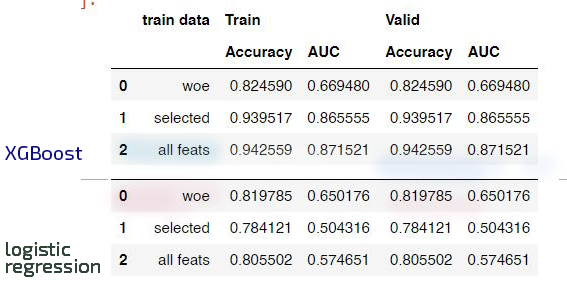

In [10]:
from IPython.display import Image
Image(filename='xgb_vs_logreg.png')

test results for both alforithms and features (ones with WOE, selected featured based on their importance, and just ol' plain use all)